In [1]:
import geopy.geocoders
import numpy as np
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from cartopy.feature import ShapelyFeature
from shapely.geometry import Point
from functools import partial
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import GoogleV3

%matplotlib notebook

### Methods Section

In [2]:
def addressGeocoded(df,gc):
    '''
    This function accepts adataframe and a geocode object and returns a geo dataframe
    
    :param df: dataframe with addresses
    :param gc: geocode object
    
    :returns geodataframe
    '''
    tmp_df = df.copy()
    tmp_df['geolocation'] = tmp_df['address'].apply(gc) #translate address into coordinate
    tmp_df['geometry'] = tmp_df['geolocation'].apply(lambda loc: tuple(loc.point[0:2]) if loc else None) #extract tuple point location
    tmp_df['geometry'] = tmp_df['geometry'].apply(Point) # convert tuple in shapely geometry point
    gdf = gpd.GeoDataFrame(tmp_df)
    gdf.set_crs("EPSG:3763", inplace=True) #Set the projection to the ETRS89/PT-TMS09
    return gdf

### Load Datasets

In [3]:
### Load Douro wine producers
douro_wine_producer_df = pd.read_excel("./data_source/douro/douro_wine_producers_list.xlsx")
douro_wine_producer_df

,producer,address
0,Niepoort,"670 Rua Candido do Reis, Vila Nova de Gaia 4400"
1,Poeira,"Provesende 5060, Villa Real"
2,Quinta do Couquinho,"Horta da Vilarica, 5160-101 Torre de Moncorvo,..."


In [4]:
### Istance Google connection for geocoding
geopy.geocoders.options.default_user_agent = 'wine_app'
geopy.geocoders.options.default_scheme = 'https'
with open("./data_source/apikey.txt") as f:   #load Google API key
    apikey = f.readline()
    f.close
geolocator = GoogleV3(api_key=apikey)
geocode = partial(geolocator.geocode, language="en")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=5)
# print(geocode)

In [5]:
douro_wine_producers_gdf = addressGeocoded(douro_wine_producer_df,geocode)

In [ ]:
douro_wine_producers_gdf

In [6]:
### Load Douro shapefile
douro_gdf = gpd.read_file("./data_source/douro/RDD_ETRS89/RDD_ETRS89.shp")

In [7]:
douro_gdf

,OBJECTID,ID,ÁREA,PERIMETRO,OBSERVAÇÕE,ID1,Shape_area,Shape_len,REGIÃO,Centroid_X,Centroid_Y,geometry
0,1,1.0,2.474209e+09,674115.534151,None,1.0,2.474209e+09,674115.534151,RDD,0,0,"MULTIPOLYGON Z (((-7.76909 41.07097 0.00000, -..."


### Create Douro Map

<IPython.core.display.Javascript object>


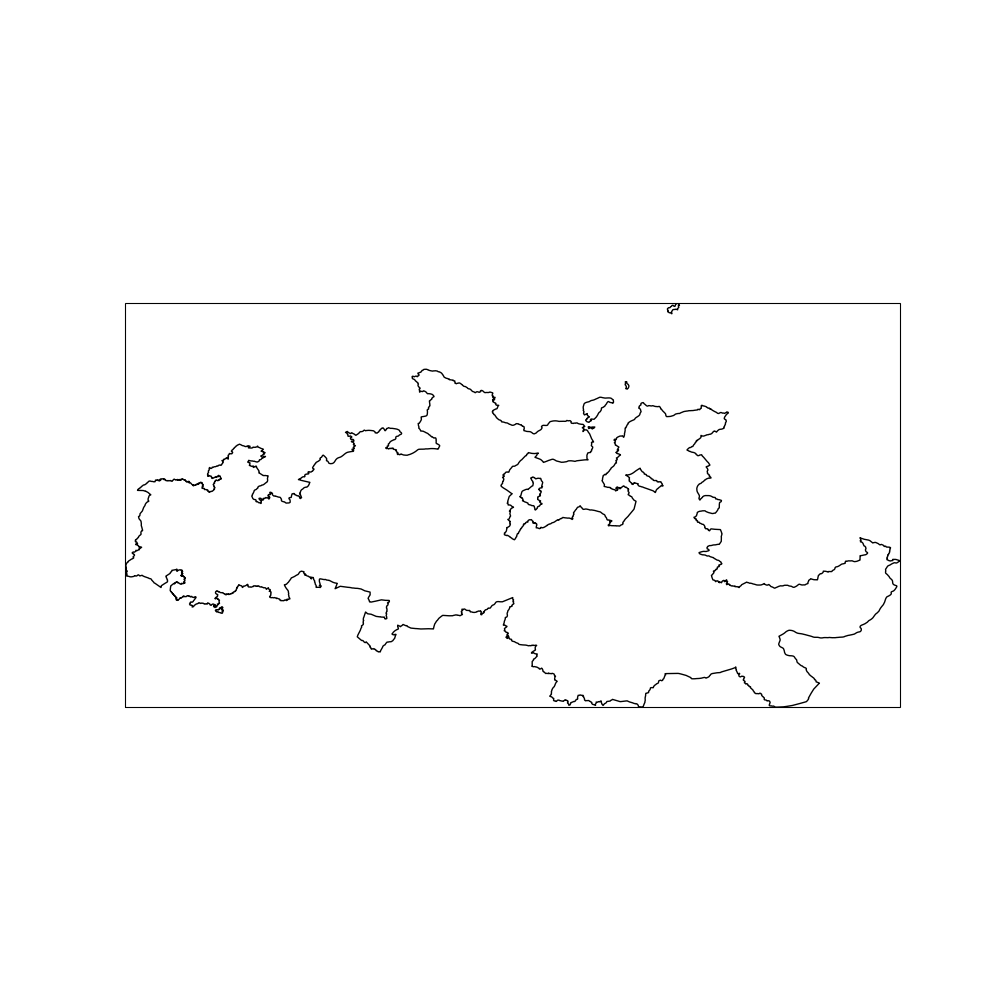

<IPython.core.display.Javascript object>


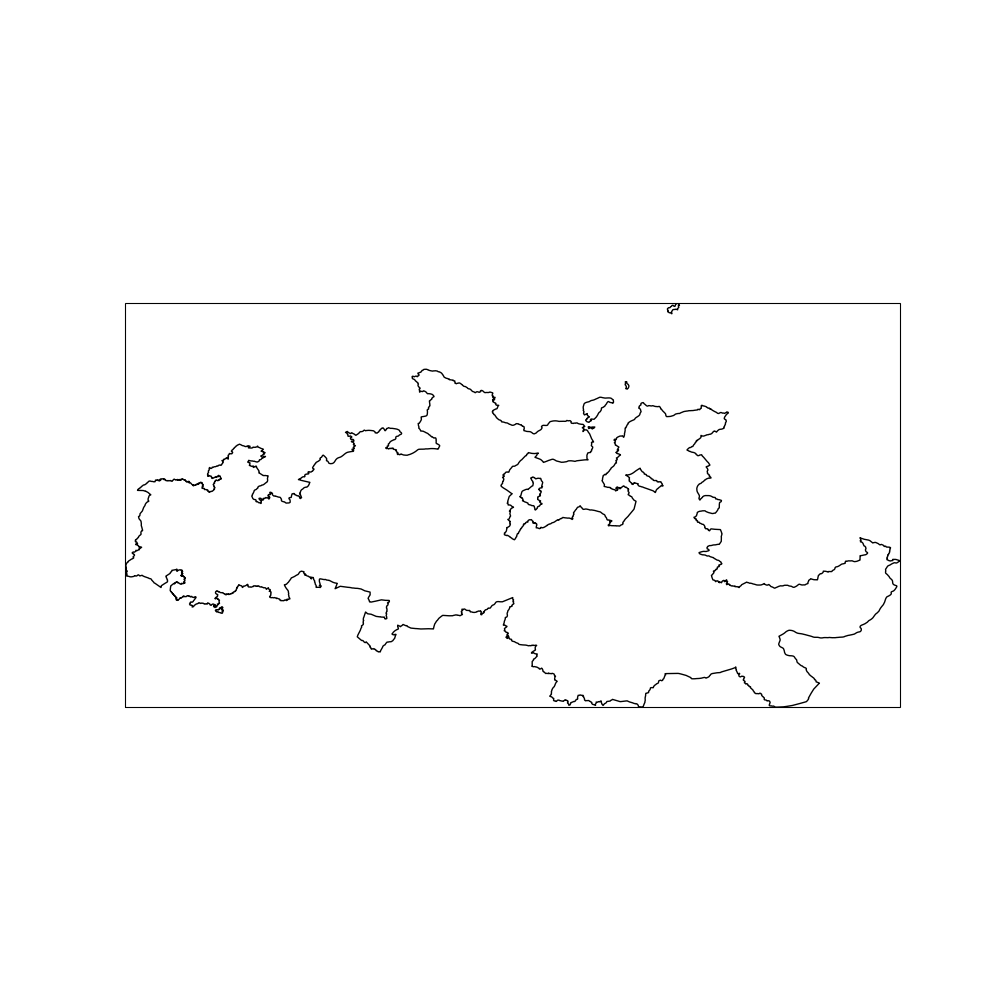

In [14]:
pt_crs = ccrs.UTM(29) #Universal Trasverse Marcator system for Portugal
douro_fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Mercator()) # create axes object with Maractor projection
douro_region = ShapelyFeature(douro_gdf['geometry'], pt_crs, edgecolor='k',facecolor='w')
ax.add_feature(douro_region) # add the douro region borders
xmin, ymin, xmax, ymax = douro_gdf.total_bounds
ax.set_extent([xmin, xmax, ymin, ymax], crs=pt_crs)
douro_fig

0    41.131039
1    41.217150
2    41.231909
dtype: float64
0   -8.610935
1   -7.566674
2   -7.122561
dtype: float64


<IPython.core.display.Javascript object>


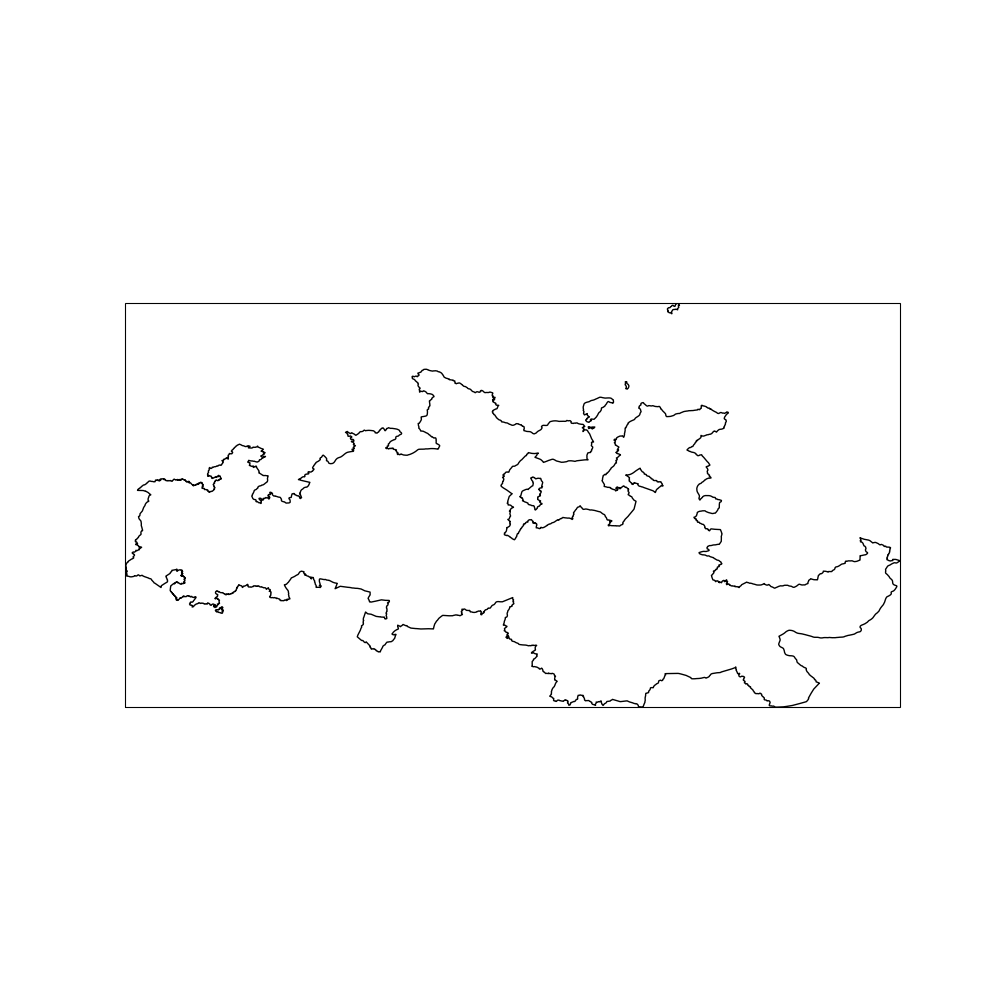

In [19]:
# add producers to the map
#plt.plot(, color='k',marker='o', transform=pt_crs)
print(douro_wine_producers_gdf['geometry'].x)
print(douro_wine_producers_gdf['geometry'].y)
ax.plot(41.131039,-8.610935, color='0.5', ms=6, transform=pt_crs)
douro_fig